# Imports

In [ ]:
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Research/Capstone/data')
!pwd

/content/drive/MyDrive/Research/Capstone/data


# Data Processing

In [ ]:
# data
df = pd.read_csv('jena.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
print('Start: ', df.iloc[0]['Date Time'])
print('End: ', df.iloc[-2]['Date Time'])

Start:  01.01.2009 00:10:00
End:  31.12.2016 23:50:00


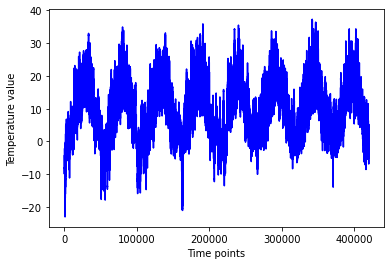

In [ ]:
# Plot temperature
plt.figure()
plt.plot(df['T (degC)'], 'b')
plt.xlabel('Time points'), plt.ylabel('Temperature value')
plt.show()

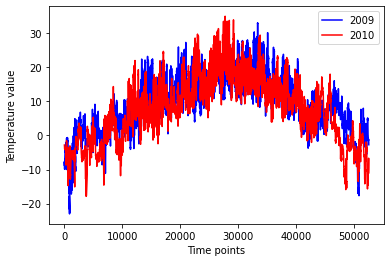

In [ ]:
# Plot temperature
plt.figure()
plt.plot(np.arange(len(df)//8), df['T (degC)'][:len(df)//8], 'b', label='2009')
plt.plot(np.arange(len(df)//8), df['T (degC)'][len(df)//8:2*len(df)//8], 'r', label='2010')
plt.legend()
plt.xlabel('Time points'), plt.ylabel('Temperature value')
plt.show()

In [ ]:
df.std()

p (mbar)            8.359454
T (degC)            8.423685
Tpot (K)            8.504820
Tdew (degC)         6.730411
rh (%)             16.477126
VPmax (mbar)        7.739481
VPact (mbar)        4.183895
VPdef (mbar)        4.897270
sh (g/kg)           2.655973
H2OC (mmol/mol)     4.235130
rho (g/m**3)       39.977065
wv (m/s)            1.541830
max. wv (m/s)       2.340482
wd (deg)           86.675965
dtype: float64

In [ ]:
# dropping the date column
df.drop('Date Time', inplace=True, axis=1)
# data standardization
df = (df - df.mean()) / df.std()
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.874159,-2.073744,-2.127168,-2.058420,1.049513,-1.323744,-1.535058,-0.780533,-1.536774,-1.539264,2.293318,-0.713638,-0.761544,-0.258736
1,0.880140,-2.120042,-2.173024,-2.114880,1.055582,-1.336664,-1.556569,-0.782575,-1.555599,-1.560514,2.344597,-0.914698,-0.868360,-0.445639
2,0.875355,-2.131913,-2.184782,-2.119337,1.085927,-1.339249,-1.558960,-0.784617,-1.559364,-1.562876,2.355604,-1.258446,-1.240078,-0.036067
3,0.872963,-2.108171,-2.160091,-2.083678,1.104134,-1.332788,-1.544619,-0.786659,-1.544304,-1.548708,2.329339,-1.161159,-1.295622,0.268515
4,0.872963,-2.103422,-2.156563,-2.079221,1.098065,-1.331496,-1.542229,-0.786659,-1.544304,-1.546347,2.324586,-1.174130,-1.240078,0.456572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,1.298828,-1.602454,-1.692121,-1.944014,-0.176429,-1.169987,-1.489646,-0.576338,-1.491593,-1.496762,1.923856,-0.947127,-0.859815,0.753079
420447,1.282080,-1.519355,-1.608639,-1.933613,-0.382169,-1.137685,-1.484866,-0.531415,-1.487827,-1.492040,1.835305,-0.642295,-0.688910,0.687317
420448,1.268922,-1.496799,-1.585122,-1.955900,-0.491411,-1.128640,-1.494426,-0.508953,-1.495358,-1.501484,1.809040,-0.681209,-0.654729,0.466956
420449,1.267725,-1.623822,-1.710933,-2.003445,-0.255326,-1.177739,-1.513547,-0.568170,-1.517948,-1.520374,1.938364,-0.415292,-0.586367,0.589250


In [ ]:
# def data_generator(data_frame, lookback, delay, min_index, max_index, shuffle=False, step=6, batch_size=128):
#     """
#     generates 1 batch of inputs
#     1 batch = 128 sequences
#     1 sequence = 120 time points / samples
#     1 sample = 14 feature values
#     inputs shape: (128, 120, 14) or (batch_size, seq_len, num_features)
#     targets shape: (128, 1), 1 target valaue for each sequence, many-to-one architecture
#     """
#     seq_len = lookback // step # sequence length, is equal to 720 / 6 = 120
#     num_features = data_frame.shape[-1] # number of features, is equal to 14
#     start = min_index + lookback # where to start drawing inputs, incremented by batch size
#     inputs, targets = {}, {}
#     while True:
#         if shuffle: # random sampling from the whole data
#             rows = np.random.randint(low=min_index+lookback, high=max_index, size=batch_size) # starting indices
#         else: # sequentially drawing from the data
#             rows = np.arange(start, start+batch_size)
#             start += batch_size
#         for i in range(batch_size):
#             indices = np.arange(rows[i]-lookback, rows[i], step)
#             inputs[i] = data_frame.iloc[indices].to_numpy().reshape(-1, num_features, 1)
#             targets[i] = data_frame.iloc[rows[i] + delay]['T (degC)']
#         yield inputs, targets

In [ ]:
def data_generator(data_frame, lookback, delay, min_index, max_index, step=6, batch_size=128, steps=50):
    """
    generates 1 batch of inputs
    1 batch = 128 sequences
    1 sequence = 120 time points / samples
    1 sample = 14 feature values
    inputs shape: (128, 120, 14) or (batch_size, seq_len, num_features)
    targets shape: (128, 1), 1 target valaue for each sequence, many-to-one architecture
    """
    inputs, targets = {}, {}
    num_features = data_frame.shape[-1] # number of features, is equal to 14
    rows = np.random.randint(low=min_index+lookback, high=max_index, size=(steps,batch_size)) # starting indices
    idx = 0
    while True:
        if idx >= steps:
            idx = 0
        row = rows[idx]
        for i in range(batch_size):
            indices = np.arange(row[i]-lookback, row[i], step)
            inputs[i] = data_frame.iloc[indices].to_numpy().reshape(-1, num_features, 1)
            targets[i] = data_frame.iloc[row[i] + delay]['T (degC)']
        idx += 1
        yield inputs, targets

In [ ]:
# lookback = 1440
# step = 6
# delay = 144
# batch_size = 64

# train_gen = data_generator(df, lookback=lookback, delay=delay, min_index=0, max_index=200000,
#                     shuffle=True, step=step, batch_size=batch_size)
# val_gen = data_generator(df, lookback=lookback, delay=delay, min_index=200001, max_index=300000,
#                     shuffle=True, step=step, batch_size=batch_size)
# test_gen = data_generator(df, lookback=lookback, delay=delay, min_index=300001, max_index=len(df)-delay-1,
#                     shuffle=True, step=step, batch_size=batch_size)

In [ ]:
# lookback = 1440/10
# step = 6
# delay = 144
# batch_size = 64
# train_steps, val_steps, test_steps = 50, 20, 100

# train_gen = data_generator(df, lookback=lookback, delay=delay, min_index=0, max_index=200000,
#                     step=step, batch_size=batch_size, steps=train_steps)
# val_gen = data_generator(df, lookback=lookback, delay=delay, min_index=200001, max_index=300000,
#                     step=step, batch_size=batch_size, steps=val_steps)
# test_gen = data_generator(df, lookback=lookback, delay=delay, min_index=300001, max_index=len(df)-delay-1,
#                     step=step, batch_size=batch_size, steps=test_steps)

In [ ]:
# seq_len = lookback/step
# seq_len

# Functions

In [ ]:
def init_orthogonal(rows, cols):
    param = np.random.randn(rows, cols)
    
    if rows < cols: 
      param = param.T
    q, r = np.linalg.qr(param) # Compute QR factorization
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r)
    ph = np.sign(d)
    q *= ph

    if rows < cols: 
      q = q.T
    return q

In [ ]:
def gradient_clip(grads, max_norm, order=1):
    total_norm = 0.0
    if order > 1:
        for i in range(order):
            total_norm += np.linalg.norm(grads[0][-i-1])
    else:
        total_norm += np.linalg.norm(grads[0])
    for i in range(1, len(grads[1:])):
        total_norm += np.linalg.norm(grads[i])
    
    total_norm = np.sqrt(total_norm)
    if total_norm > max_norm:
        if order > 1:
            for i in range(order):
                grads[0][-i-1] *= max_norm / total_norm
        else:
            grads[0] *= max_norm / total_norm
        for i in range(1, len(grads[1:])):
            grads[i] *= max_norm / total_norm
    """
    # andrej
    for i in range(len(grads)):
        np.clip(grads[i], -5, 5, out=grads[i]) # clip to mitigate exploding gradients
    """
    return grads

In [ ]:
def find_loss(outputs, targets):
    loss = 0.0
    for n in range(len(outputs)):
        #loss += (targets[n] - outputs[n].item())**2
        loss += abs(targets[n] - outputs[n])
    loss /= len(outputs)
    return loss

In [ ]:
def update_parameters(params, grads, lr, order=0):
    if order > 1:
        for i in range(order):
            params[0][-i-1] -= grads[0][-i-1] * lr
    else:
        params[0] -= grads[0] * lr
    for i in range(1, len(params[1:])):
        params[i] -= grads[i] * lr
    return params

# Vanilla RNN

In [ ]:
class RNN():
    def __init__(self, hidden_size, input_size, out_size):
        V = np.random.randn(hidden_size, hidden_size)*0.1 # W_hh
        U = np.random.randn(hidden_size, input_size)*0.1  # W_hx
        W = np.random.randn(out_size, hidden_size)*0.1    # W_hy
        b_hidden = np.zeros((hidden_size, 1))              # b_h
        b_out = np.zeros((out_size, 1))                    # b_y
        self.params = [V, U, W, b_hidden, b_out]
        self.best = [V, U, W, b_hidden, b_out]
    
    def forward(self, inputs, hidden_state, best=False):
        if best: 
            V, U, W, b_hidden, b_out = self.best    
        else: 
            V, U, W, b_hidden, b_out = self.params
        V, U, W, b_hidden, b_out = self.params
        outputs, hidden_states = {}, {}
        for n in range(len(inputs)):
            hidden_states[n] = {}
            hidden_states[n][-1] = np.copy(hidden_state)
            for t in range(len(inputs[n])):
                hidden_states[n][t] = np.tanh(np.dot(U, inputs[n][t]) + np.dot(V, hidden_states[n][t-1]) + b_hidden)
            outputs[n] = np.copy((np.dot(W, hidden_states[n][t]) + b_out).item())
        return outputs, hidden_states

    def backward(self, inputs, outputs, hidden_states, targets, clip_norm):
        V, U, W, b_hidden, b_out = self.params
        dV, dU, dW = np.zeros_like(V), np.zeros_like(U), np.zeros_like(W)
        db_hidden, db_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
        loss = 0.0
        N, T = len(inputs), len(inputs[0])
        for n in range(N): # iterate over sequences in a batch, 128
            #loss += (outputs[n] - targets[n])**2
            loss += abs(outputs[n] - targets[n])
            #do = (outputs[n] - targets[n])*2
            do = 1.0 if outputs[n] >= targets[n] else -1.0
            dW += np.dot(do, hidden_states[n][T-1].T)
            db_out += do
            dh = np.dot(W.T, do)
            for t in reversed(range(T)):
                df = (1 - hidden_states[n][t]*hidden_states[n][t]) * dh
                db_hidden += df
                dU += np.dot(df, inputs[n][t].T)
                dV += np.dot(df, hidden_states[n][t-1].T)
                dh = np.dot(V.T, df)    
        loss /= N
        dV, dU, dW, db_hidden, db_out = dV/N, dU/N, dW/N, db_hidden/N, db_out/N
        grads = [dV, dU, dW, db_hidden, db_out]
        grads = gradient_clip(grads, clip_norm)
        return loss, grads

    def train(self, train_set, valid_set, hidden_state, num_epochs, lr, clip_norm, train_steps=100, val_steps=100):
        training_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            epoch_training_loss = 0.0
            epoch_validation_loss = 0.0
            min_valid_loss = 1e6

            for train_step in range(train_steps):
                inputs, targets = next(train_set)
                outputs, hidden_states = self.forward(inputs, hidden_state)
                loss, grads = self.backward(inputs, outputs, hidden_states, targets, clip_norm)
                self.params = update_parameters(self.params, grads, lr)
                epoch_training_loss += loss
            
            for val_step in range(val_steps):
                inputs, targets = next(valid_set)
                outputs, _ = self.forward(inputs, hidden_state)
                loss = find_loss(outputs, targets)
                if loss < min_valid_loss:
                    self.best = self.params.copy()
                    min_valid_loss = loss
                epoch_validation_loss += loss
                    
            training_loss.append(epoch_training_loss/train_steps)
            validation_loss.append(epoch_validation_loss/val_steps)

            if epoch % 2 == 0:
                print(f'Epoch {epoch}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        return training_loss, validation_loss

    def test(self, test_set, hidden_state, test_steps=100):
        test_loss = 0.0
        for test_step in range(test_steps):
            inputs, targets = next(test_set)
            outputs, _ = self.forward(inputs, hidden_state, best=True)
            test_loss += find_loss(outputs, targets)
        test_loss /= test_steps
        print("Test loss: ", test_loss)
        return test_loss

Experiment: 0
Epoch 0, training loss: 0.6801830995886471, validation loss: 0.4399087892648705
Epoch 2, training loss: 0.35468553992781915, validation loss: 0.31127997647541006
Epoch 4, training loss: 0.34358934068970315, validation loss: 0.30459750047842266
Epoch 6, training loss: 0.3388561411989576, validation loss: 0.30226213262884516
Epoch 8, training loss: 0.3357932713606149, validation loss: 0.30114464753245296
Epoch 10, training loss: 0.33345597087610895, validation loss: 0.30028632140325245
Epoch 12, training loss: 0.33137173181780377, validation loss: 0.2993507007994286
Epoch 14, training loss: 0.32952300300808696, validation loss: 0.2984800765557071
Epoch 16, training loss: 0.3277838683210061, validation loss: 0.29794033318578006
Epoch 18, training loss: 0.32624949348367216, validation loss: 0.29764966686929817
Epoch 20, training loss: 0.3248994982321037, validation loss: 0.29721612229954697
Epoch 22, training loss: 0.32378792343363344, validation loss: 0.2972157873331899
Epoc

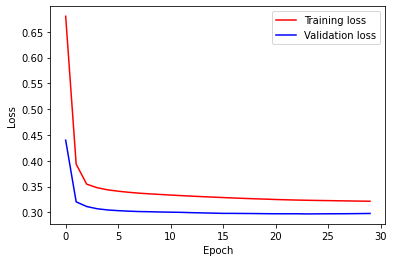

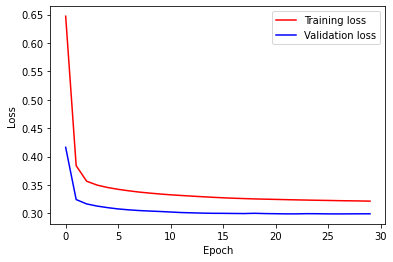

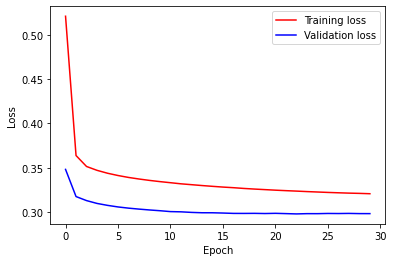

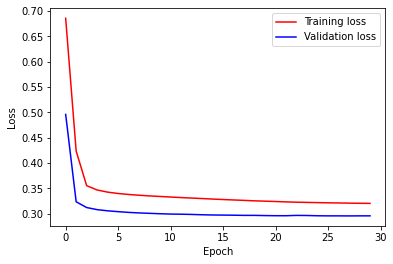

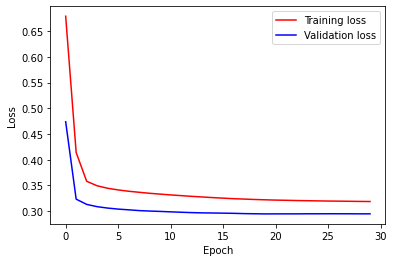

In [ ]:
### Train Vanilla RNN ###
# Hyperparameters
hidden_size = 16
gradient_clip_norm = 1.0
learning_rate = 0.01
num_epochs = 30

# experiments with Vanilla RNN
num_exp = 5 # number of experiments
train_results, val_results, test_loss_results = [], [], []
for n in range(num_exp):
    print('Experiment:', n)
    rnn_model = RNN(hidden_size=hidden_size, input_size=14, out_size=1)
    hidden_state = np.zeros((hidden_size, 1))  # Initial hidden_state
    train_loss, valid_loss = rnn_model.train(train_set=train_gen, valid_set=val_gen, 
                                            hidden_state=hidden_state, num_epochs=num_epochs, 
                                            lr=learning_rate, clip_norm=gradient_clip_norm, 
                                            train_steps=train_steps, val_steps=val_steps)
    test_loss = rnn_model.test(test_set=test_gen, hidden_state=hidden_state, test_steps=test_steps)
    train_results.append(train_loss)
    val_results.append(valid_loss)
    test_loss_results.append(test_loss)
    # Plot training and validation loss
    epoch = np.arange(len(train_loss))
    plt.figure()
    plt.plot(epoch, train_loss, 'r', label='Training loss',)
    plt.plot(epoch, valid_loss, 'b', label='Validation loss')
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('Loss')
    plt.savefig(f'jena_{seq_len}_exp_{n}_rnn_h{hidden_size}.png')
print(f'Average jena test loss: seq_len: {seq_len}, hs: {hidden_size}, {np.average(test_loss_results)}')

# HORNN

In [ ]:
class HORNN():
    def __init__(self, hidden_size, input_size, out_size, order):
        self.order = order
        V = {}
        for i in range(self.order):
            V[-i-1] = np.random.randn(hidden_size, hidden_size)*0.1 # W_hh
        U = np.random.randn(hidden_size, input_size)*0.1            # W_hx
        W = np.random.randn(out_size, hidden_size)*0.1              # W_hy
        b_hidden = np.zeros((hidden_size, 1))                        # b_h
        b_out = np.zeros((out_size, 1))                              # b_y
        self.params = [V, U, W, b_hidden, b_out]
        self.best = [V, U, W, b_hidden, b_out]

    def forward(self, inputs, hidden_state, best=False):
        if best: 
            V, U, W, b_hidden, b_out = self.best    
        else: 
            V, U, W, b_hidden, b_out = self.params
        outputs, hidden_states = {}, {}
        for n in range(len(inputs)):
            hidden_states[n] = {}
            for i in range(self.order): # for the history window
                hidden_states[n][-i-1] = np.copy(hidden_state)
            for t in range(len(inputs[n])):
                s = np.zeros_like(hidden_state)
                for i in range(self.order): # order = 3: -1, -2, -3; 
                    s += np.dot(V[-i-1], hidden_states[n][t-i-1])
                hidden_states[n][t] = np.tanh(np.dot(U, inputs[n][t]) + s + b_hidden)
            outputs[n] = np.copy((np.dot(W, hidden_states[n][t]) + b_out).item())
        return outputs, hidden_states
    
    def backward(self, inputs, outputs, hidden_states, targets, clip_norm):
        V, U, W, b_hidden, b_out = self.params
        dV = {}
        for i in range(self.order):
            dV[-i-1] = np.zeros_like(V[-i-1])
        dU, dW = np.zeros_like(U), np.zeros_like(W)
        db_hidden, db_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
        
        loss = 0.0
        N, T = len(inputs), len(inputs[0])
        for n in range(N):
            #loss += (targets[n] - outputs[n].item())**2
            loss += abs(targets[n] - outputs[n].item())
            #do = (outputs[n] - targets[n])*2
            do = 1.0 if outputs[n] >= targets[n] else -1.0
            dW += np.dot(do, hidden_states[n][T-1].T)    # uses only last hidden state
            db_out += do
            
            # HORNN update
            #########################
            arrayOfM, arrayOfs = {}, {}
            for i in range(self.order):
                arrayOfM[i], arrayOfs[i] = 0.0, 0.0

            l = np.dot(W.T, do)
            one = 1.0
            for t in reversed(range(T)):
                M = arrayOfM[0]
                for i in range(self.order-1):
                    M = M * arrayOfs[i] + arrayOfM[i+1]
                
                M = M * arrayOfs[self.order-1] + one  # M update, one = 1 only at t + T
                M *= l                                # l is 1 after t = T
                for i in range(self.order-1):
                    arrayOfM[i] = arrayOfM[i+1]
                arrayOfM[self.order-1] = M

                df = (1 - hidden_states[n][t] * hidden_states[n][t])
                r = df * M
                for i in range(self.order):
                    dV[-i-1] += np.dot(r, hidden_states[n][t-i-1].T)
                db_hidden += r
                dU += np.dot(r, inputs[n][t].T)

                for s in range(self.order-1):                   
                    arrayOfs[s] = arrayOfs[s+1] 
                arrayOfs[self.order-1] = np.dot(V[-1].T, df)
                
                one, l = 0.0, 1.0
            #########################
        
        loss /= N
        for i in range(self.order):
            dV[-i-1] /= N
        dU, dW, db_hidden, db_out = dU/N, dW/N, db_hidden/N, db_out/N
        grads = [dV, dU, dW, db_hidden, db_out]
        grads = gradient_clip(grads, clip_norm, self.order)
        return loss, grads
    
    def train(self, train_set, valid_set, hidden_state, num_epochs, lr, clip_norm, train_steps=100, val_steps=100):
        training_loss, validation_loss = [], []

        for epoch in range(num_epochs):
            epoch_training_loss, epoch_validation_loss = 0.0, 0.0
            min_valid_loss = 1e6
            
            for train_step in range(train_steps):
                inputs, targets = next(train_set)
                outputs, hidden_states = self.forward(inputs, hidden_state)
                loss, grads = self.backward(inputs, outputs, hidden_states, targets, clip_norm)
                self.params = update_parameters(self.params, grads, lr, self.order)
                epoch_training_loss += loss

            for val_step in range(val_steps):
                inputs, targets = next(valid_set)
                outputs, _ = self.forward(inputs, hidden_state)
                loss = find_loss(outputs, targets)
                if loss < min_valid_loss:
                    self.best = self.params.copy()
                epoch_validation_loss += loss

            training_loss.append(epoch_training_loss/train_steps)
            validation_loss.append(epoch_validation_loss/val_steps)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')        
        
        return training_loss, validation_loss

    def test(self, test_set, hidden_state, test_steps=100):
        test_loss = 0.0
        for test_step in range(test_steps):
            inputs, targets = next(test_set)
            outputs, _ = self.forward(inputs, hidden_state, best=True)
            test_loss += find_loss(outputs, targets)
        test_loss /= test_steps
        print("Test loss: ", test_loss)
        return test_loss

## Train HORNN

In [ ]:
### Train HORNN ###
# Hyperparameters
hidden_size = 16
gradient_clip_norm = 1.0
learning_rate = 0.01
num_epochs = 30
num_exp = 3
batch_size = 64
step = 6
delay = 144
train_steps, val_steps, test_steps = 50, 20, 100
# orders = [2, 3, 5]
# seq_lens = [24, 120, 240]
orders = [5]
seq_lens = [240]

HORNN 5 Experiment: 0; seq_len: 240
Epoch 0, training loss: 0.5474072039317697, validation loss: 0.43473479514243374
Epoch 10, training loss: 0.34992945659043484, validation loss: 0.30408733909881486
Epoch 20, training loss: 0.3357064020631435, validation loss: 0.29633882844886705
Test loss:  0.31755938413194623
HORNN 5 Experiment: 1; seq_len: 240
Epoch 0, training loss: 0.6311679008842346, validation loss: 0.5202315629234772


KeyboardInterrupt: ignored

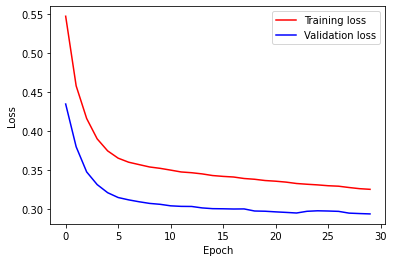

In [ ]:
hornn_test_results = {}
for seq_len in seq_lens:
    lookback = seq_len*step

    train_gen = data_generator(df, lookback=lookback, delay=delay, min_index=0, max_index=200000,
                        step=step, batch_size=batch_size, steps=train_steps)
    val_gen = data_generator(df, lookback=lookback, delay=delay, min_index=200001, max_index=300000,
                        step=step, batch_size=batch_size, steps=val_steps)
    test_gen = data_generator(df, lookback=lookback, delay=delay, min_index=300001, max_index=len(df)-delay-1,
                        step=step, batch_size=batch_size, steps=test_steps)

    hornn_test_results[seq_len] = {}
    for order in orders:
        hornn_test_results[seq_len][order] = {}
        test_loss_results, test_acc_results = [], []
        for n in range(num_exp):
            print(f'HORNN {order} Experiment: {n}; seq_len: {seq_len}')
            hornn_model = HORNN(hidden_size, input_size=14, out_size=1, order=order)
            hidden_state = np.zeros((hidden_size, 1))  # Initial hidden_state
            hornn_train_loss, hornn_valid_loss = hornn_model.train(train_set=train_gen, valid_set=val_gen, 
                                                    hidden_state=hidden_state, num_epochs=num_epochs, 
                                                    lr=learning_rate, clip_norm=gradient_clip_norm, 
                                                    train_steps=train_steps, val_steps=val_steps)
            hornn_test_loss = hornn_model.test(test_set=test_gen, hidden_state=hidden_state, test_steps=test_steps)
            test_loss_results.append(hornn_test_loss)
            # Plot training and validation loss
            epoch = np.arange(len(hornn_train_loss))
            plt.figure()
            plt.plot(epoch, hornn_train_loss, 'r', label='Training loss',)
            plt.plot(epoch, hornn_valid_loss, 'b', label='Validation loss')
            plt.legend()
            plt.xlabel('Epoch'), plt.ylabel('Loss')
            plt.savefig(f'jena_{seq_len}__hornn{order}_exp_{n}.png')
        
        print(f'Seq_len: {seq_len}; HORNN-{order} average char test loss: {np.average(test_loss_results)}')
        hornn_test_results[seq_len][order]['loss'] = np.average(test_loss_results)
        hornn_test_results[seq_len][order]['all_loss'] = test_loss_results.copy()